# Dominik Czech - Lab 2 - Logistic Regression (SGD vs Mini-batch)


In [1]:
from six import print_
from sklearn.model_selection import train_test_split
import numpy as np

from fetch_and_preprocess import fetch_heart_data, preprocess_heart_data

## Load and preprocess the data

In [2]:
# fetch dataset 
df = fetch_heart_data()

#preprocess
X_processed, y = preprocess_heart_data(df)

### Create a Binary Target for Regression

In [3]:
# 0 - no heart disease, 1 - heart disease (no matter which type)
y_binary = df['num'].apply(lambda x: 1 if x > 0 else 0)

### Split the set into training and validation sets

In [4]:
# 80:20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_binary, test_size=0.2, random_state=42)

## Logistic Regression Model

In [5]:
class GradientLogisticRegression:
    def __init__(self, learning_rate=0.1, max_iter=1000, random_state=None, tol=1e-4, n_epoch_no_change=10):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        
        self.weights = None
        self.bias = None
       
        self.random_state = random_state
        self.rng = np.random.RandomState(self.random_state) # for reproducibility
    
        self.loss_history = []
        self.tol = tol
        self.n_epoch_no_improve = n_epoch_no_change
        
    
    def _initialize_weights(self, n_features):
        self.weights = self.rng.rand(n_features) * 0.01
        self.bias = 0
    
    
    def _sigmoid(self, n):
        n = np.clip(n, -40.0, 40.0) # if n was too large or too small, exp(-n) would overflow
        return 1 / (1 + np.exp(-n))
    
    def _compute_loss(self, X, y):
        z = np.dot(X, self.weights) + self.bias #sample * weights + bias
        y_predicted_prob = self._sigmoid(z)
        
        # to avoid log(0)
        eps = 1e-15 
        y_predicted_prob = np.clip(y_predicted_prob, eps, 1 - eps)
        
        # cross-entropy loss
        # L = -y log(p(x)) - (1 - y) log(1 - p(x))
        loss = -np.mean(y * np.log(y_predicted_prob) + (1 - y) * np.log(1 - y_predicted_prob))
        
        return loss
    
    
    
    def _iteration(self, X, y_np):
        n_samples, n_features = X.shape
        
        for i in range(n_samples):
            y_desired = y_np[i]
            feature_values = X[i]
            
            # 1. calculate Wx + b
            z = np.dot(feature_values, self.weights) + self.bias
            
            #2. p(x) = sigmoid(Wx+b)
            output = self._sigmoid(z)
        
            error = output - y_desired
            
            #3. update weights
            # for j in range(n_features):
            #     # dL/dw = -(y - p(x))x = (p(x) - y)x = error * x
            #     delta_w = self.learning_rate * feature_values[j] * error
            #     # w' = w - α * (error * x)
            #     self.weights[j] -= delta_w
            
            # update weights (improved vectorized version)
            # w' = w - α * (error * x)
            self.weights -= self.learning_rate * feature_values * error
            
            #4. update bias
            
            # b' = b - α * error
            self.bias -= self.learning_rate * error
    
    def fit_sgd(self, X, y):
        n_samples, n_features = X.shape
        y_np = y.values
        
        self._initialize_weights(n_features)
        
        no_change_count = 0
        
        for i in range(self.max_iter):
            order = self.rng.permutation(n_samples)
            X_epoch = X[order]
            y_epoch = y_np[order]
            self._iteration(X_epoch, y_epoch)
            
            epoch_loss = self._compute_loss(X, y_np)
            
            if i > 0 and self.loss_history[-1] - epoch_loss < self.tol:
                no_change_count += 1
            else:
                no_change_count = 0
            
            self.loss_history.append(epoch_loss)
            
            if no_change_count >= self.n_epoch_no_improve:
                print_(f"[SGD] Early stopping at iteration {i+1} due to no improvement in loss.")
                break
            
    
    def fit_mini_batch(self, X, y, batch_size=16):
        n_samples, n_features = X.shape
        
        self._initialize_weights(n_features)
        
        y_np = y.to_numpy()
        
        no_change_count = 0
        
        for i in range(self.max_iter):
            order = self.rng.permutation(n_samples)
            X_shuffled = X[order]
            y_shuffled = y_np[order]
            
            for start in range(0, n_samples, batch_size):
                end = start + batch_size #python handles slices that go out of bounds natively
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]
            
                # p(x) = sigmoid(Wx+b)
                z = np.dot(X_batch, self.weights) + self.bias # z = Wx + b
                y_predicted = self._sigmoid(z)  # sigmoid(Wx + b)
                
                # gradient calculation (mean over the batch)
                error = y_predicted - y_batch   # error = p(x) - y
                
                # dL/dw = -(y - p(x))x = (p(x) - y)x = error * x
                # for the whole batch: (1/n) * sum(error * x)
                delta_w = (1/X_batch.shape[0]) * np.dot(X_batch.transpose(), error)
                
                # b' = b - α * error
                # for the whole batch: (1/n) * sum(error)
                delta_b = (1/X_batch.shape[0]) * np.sum(error)
                
                # update weights and bias
                self.weights -= self.learning_rate * delta_w
                self.bias -= self.learning_rate * delta_b
            
            epoch_loss = self._compute_loss(X, y_np)
            
            if i > 0 and self.loss_history[-1] - epoch_loss < self.tol:
                no_change_count += 1
            else:
                no_change_count = 0
            
            self.loss_history.append(epoch_loss)
            
            if no_change_count >= self.n_epoch_no_improve:
                print_(f"[Mini-batch] Early stopping at iteration {i+1} due to no improvement in loss.")
                break
                
    

    def predict(self, X):
        if self.weights is None:
            raise Exception("Model is not trained yet. Call 'fit' with training data first.")
        
        z = np.dot(X, self.weights) + self.bias
        y_predicted_prob = self._sigmoid(z)
        y_predicted = (y_predicted_prob >= 0.5).astype(int)
        return y_predicted

## Train and evaluate the model (single 80:20 train/test split)

In [12]:
sgdLogReg = GradientLogisticRegression(learning_rate=0.1, max_iter=10000, random_state=42, tol=1e-5, n_epoch_no_change=10)

sgdLogReg.fit_sgd(X_train, y_train)
print("Trained weights and bias [SGD]:")
print(sgdLogReg.weights)
print(sgdLogReg.bias)

# Predict probabilities and classes on the test set
sgd_y_pred = sgdLogReg.predict(X_test)

# compute accuracy
acc = np.mean(sgd_y_pred == y_test)
print(f"Accuracy (per-sample): {acc * 100:.2f}%\n")

minibatchLogReg = GradientLogisticRegression(learning_rate=0.1, max_iter=10000, random_state=42, tol=1e-5, n_epoch_no_change=10)
minibatchLogReg.fit_mini_batch(X_train, y_train, batch_size=16)
print("Trained weights and bias [Mini-batch]:")
print(minibatchLogReg.weights)
print(minibatchLogReg.bias)

# Predict probabilities and classes on the test set
minibatch_y_pred = minibatchLogReg.predict(X_test)
# compute accuracy
acc = np.mean(minibatch_y_pred == y_test)
print(f"Accuracy (mini-batch): {acc * 100:.2f}%")

Trained weights and bias [SGD]:
[-0.1231761   0.20721908  0.36474358 -0.04896459  0.73958632  1.68287301
 -1.49363158  1.01885172 -1.28862817  0.41674105 -0.69866237  1.10952384
  0.12736689 -0.60094154 -0.34475356  0.12054946 -0.25312364 -0.63165937
  0.15720393 -0.95912451  1.11449858 -0.62897077 -0.27016166 -1.21049268
  1.00777764]
-0.4840224609341942
Accuracy (per-sample): 85.25%

Trained weights and bias [Mini-batch]:
[ 0.05131946  0.39325156  0.44426094 -0.14627028  0.52042141  1.51606242
 -1.31425782  0.94828685 -1.25543684  0.32802226 -0.57441618  1.14961401
  0.05024884 -0.41501459 -0.28732303  0.14349159 -0.22468742 -0.49427023
  0.12862367 -0.85986798  1.02791298 -0.53283282 -0.12516067 -0.98239459
  0.74348746]
-0.37521357111276993
Accuracy (mini-batch): 83.61%


For a single 80:20 train/test split and given hyperparameters, both methods achieve an accuracy over 80%.

- SGD (per-sample): 85.25%
- Mini-batch: 83.61%

The weights are different, which is expected due to the optimization paths taken by each of the methods during training. 

The weights remaining small numbers proves that our initialization and learning rate strategies are appropriate.

## 5-Fold Cross-Validation with Time Measurement

In [7]:
#Generated by GPT-5

import time
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def run_cross_validation(X_data, y_data, learning_rate, max_iter, batch_size, random_seed, tol=1e-4, n_epoch_no_change=10):
    """
    Runs 5-fold CV. For each fold, trains SGD (per-sample) and Mini-Batch
    and records accuracy and training time for both methods.
    """
    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=random_seed)

    results = {
        "folds": [],
        "sgd_accuracies": [], "minibatch_accuracies": [],
        "sgd_times": [], "minibatch_times": []
    }

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_data, y_data), start=1):
        X_train_fold, X_val_fold = X_data[train_idx], X_data[val_idx]
        y_train_fold = y_data.iloc[train_idx] if hasattr(y_data, "iloc") else y_data[train_idx]
        y_val_fold = y_data.iloc[val_idx] if hasattr(y_data, "iloc") else y_data[val_idx]

        # SGD (per-sample)
        model_sgd = GradientLogisticRegression(learning_rate=learning_rate, max_iter=max_iter, random_state=random_seed, tol=tol, n_epoch_no_change=n_epoch_no_change)
        t0 = time.time()
        model_sgd.fit_sgd(X_train_fold, y_train_fold)
        sgd_time = time.time() - t0
        sgd_pred = model_sgd.predict(X_val_fold)
        sgd_acc = accuracy_score(y_val_fold, sgd_pred)

        # Mini-batch
        model_mb = GradientLogisticRegression(learning_rate=learning_rate, max_iter=max_iter, random_state=random_seed, tol=tol, n_epoch_no_change=n_epoch_no_change)
        t0 = time.time()
        model_mb.fit_mini_batch(X_train_fold, y_train_fold, batch_size=batch_size)
        mb_time = time.time() - t0
        mb_pred = model_mb.predict(X_val_fold)
        mb_acc = accuracy_score(y_val_fold, mb_pred)

        results["folds"].append(fold_idx)
        results["sgd_accuracies"].append(sgd_acc)
        results["minibatch_accuracies"].append(mb_acc)
        results["sgd_times"].append(sgd_time)
        results["minibatch_times"].append(mb_time)

    return results

In [8]:
from matplotlib import pyplot as plt

def plot_results_per_fold(results, use_log_time=True):
    """
    Single plot per fold: bars for accuracy (left y-axis) and lines for time (right y-axis).
    """
    folds = np.array(results["folds"])
    sgd_acc = np.array(results["sgd_accuracies"])
    mb_acc = np.array(results["minibatch_accuracies"])
    sgd_time = np.array(results["sgd_times"])
    mb_time = np.array(results["minibatch_times"])

    x = np.arange(len(folds))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(12, 6))

    bars_sgd = ax1.bar(x - width/2, sgd_acc, width, label="SGD Accuracy", color="skyblue", edgecolor="black")
    bars_mb = ax1.bar(x + width/2, mb_acc, width, label="Mini-Batch Accuracy", color="lightgreen", edgecolor="black")

    ax1.set_ylabel("Accuracy")
    ax1.set_xlabel("Fold")
    ax1.set_xticks(x)
    ax1.set_xticklabels([f"F{f}" for f in folds])
    ax1.set_ylim(0.0, 1.05)

    ax2 = ax1.twinx()
    line_sgd, = ax2.plot(x, sgd_time, marker="o", color="blue", label="SGD Time (s)")
    line_mb, = ax2.plot(x, mb_time, marker="o", linestyle="--", color="green", label="Mini-Batch Time (s)")
    ax2.set_ylabel("Training time (s)")
    if use_log_time:
        ax2.set_yscale("log")
    ax2.grid(True, which="both", axis="y", linestyle=":", alpha=0.4)

    # Combined legend
    handles = [bars_sgd, bars_mb, line_sgd, line_mb]
    labels = ["SGD Accuracy", "Mini-Batch Accuracy", "SGD Time (s)", "Mini-Batch Time (s)"]
    ax1.legend(handles, labels, loc="upper center", ncol=2, frameon=True)

    fig.suptitle("Per-fold: Accuracy (bar) and Training Time (line)")
    fig.tight_layout()
    plt.show()

In [9]:
def print_formatted_results(results):
    folds = np.asarray(results["folds"])
    sgd_acc = np.asarray(results["sgd_accuracies"]) * 100.0
    mb_acc  = np.asarray(results["minibatch_accuracies"]) * 100.0
    sgd_t   = np.asarray(results["sgd_times"])
    mb_t    = np.asarray(results["minibatch_times"])

    # Per-fold table
    print("\n--- Per-fold metrics ---")
    header = f"{'Fold':>4} | {'SGD Acc (%)':>12} | {'Mini Acc (%)':>12} | {'SGD Time (s)':>12} | {'Mini Time (s)':>13}"
    print(header)
    print("-" * len(header))
    for i in range(len(folds)):
        print(f"{folds[i]:>4} | {sgd_acc[i]:12.2f} | {mb_acc[i]:12.2f} | {sgd_t[i]:12.4f} | {mb_t[i]:13.4f}")

    # Summary
    print("\n--- Summary ---")
    print(f"SGD   Accuracy: mean={sgd_acc.mean():.2f}%  std={sgd_acc.std(ddof=0):.2f}%")
    print(f"Mini  Accuracy: mean={mb_acc.mean():.2f}%  std={mb_acc.std(ddof=0):.2f}%")
    print(f"SGD   Time:     mean={sgd_t.mean():.4f}s  std={sgd_t.std(ddof=0):.4f}s")
    print(f"Mini  Time:     mean={mb_t.mean():.4f}s  std={mb_t.std(ddof=0):.4f}s")
    if np.all(mb_t > 0):
        speedup = sgd_t.mean() / mb_t.mean()
        print(f"Speedup (Mini vs SGD): {speedup:.2f}x")

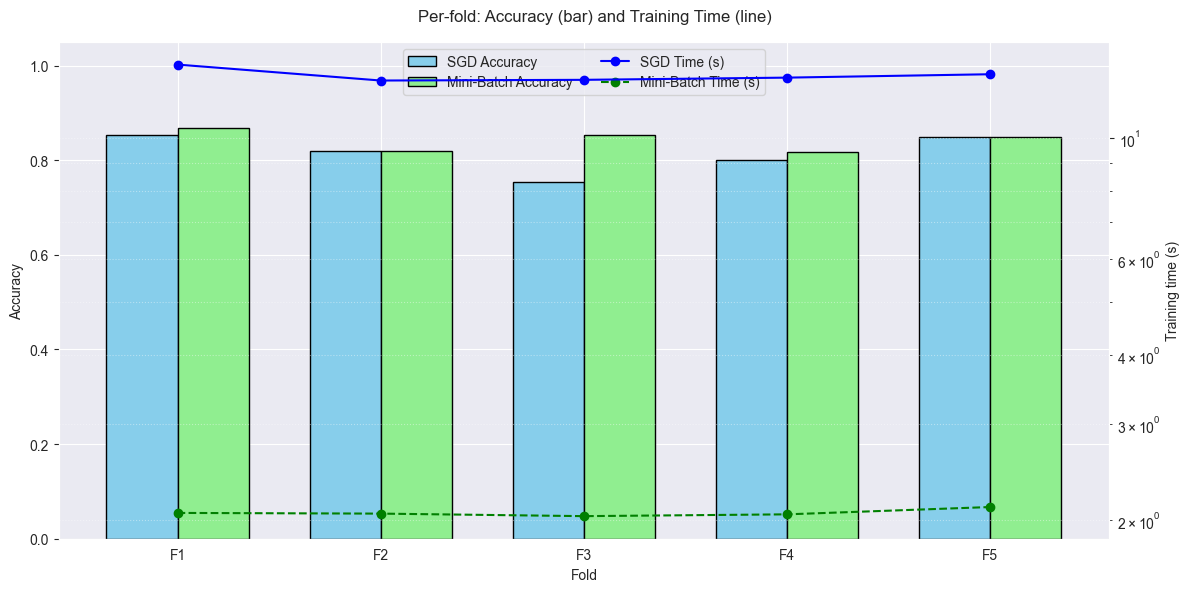


--- Per-fold metrics ---
Fold |  SGD Acc (%) | Mini Acc (%) | SGD Time (s) | Mini Time (s)
-----------------------------------------------------------------
   1 |        85.25 |        86.89 |      13.6193 |        2.0581
   2 |        81.97 |        81.97 |      12.7339 |        2.0521
   3 |        75.41 |        85.25 |      12.7710 |        2.0304
   4 |        80.00 |        81.67 |      12.8904 |        2.0459
   5 |        85.00 |        85.00 |      13.0758 |        2.1099

--- Summary ---
SGD   Accuracy: mean=81.52%  std=3.63%
Mini  Accuracy: mean=84.15%  std=2.02%
SGD   Time:     mean=13.0181s  std=0.3234s
Mini  Time:     mean=2.0593s  std=0.0270s
Speedup (Mini vs SGD): 6.32x


In [10]:
# Hyperparameters
LEARNING_RATE = 0.1
MAX_ITER = 10000
BATCH_SIZE = 16
SEED = 42
TOL = 1e-5
N_EPOCH_NO_CHANGE = 10

experiment_results = run_cross_validation(X_processed, y_binary, LEARNING_RATE, MAX_ITER, BATCH_SIZE, SEED, TOL, N_EPOCH_NO_CHANGE)
plot_results_per_fold(experiment_results)
print_formatted_results(experiment_results)


### Key takeaways from the 5-Fold Cross-Validation Experiment
- **Minibatch** proved to be a better method than SGD to train the model for **this specific set of hyperparameters on this dataset**.
    - It achieved a **slightly higher mean accuracy** (84.15% vs 81.52%) with lower standard deviation proving to be more **consistent and stable**.
    - It was **significantly faster**, with a mean training time of 2 seconds, compared to 13 seconds for SGD. This resulted in a **speedup of over 6x**.  
        - The speedup could be further optimized by using GPU for matrix operations. 
- To **properly compare the two methods**, we would need to do a **hyperparameter tuning for both methods separately**, to compare the best possible results for each method.